### 导入需要的包

In [1]:
import torch
import os
import random
import seaborn as sns
import gymnasium as gym
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from torch.distributions import Categorical
from multiprocessing import Process, Pipe
from multiprocessing_env import SubprocVecEnv

### 建立Actor和Critic网络

这里针对简单的环境建立一个ActorCritic网络，并且只针对离散动作空间进行处理，演员和评论家共享参数。

In [2]:
class ActorCritic(nn.Module):
    ''' A2C网络模型，包含一个Actor和Critic
    '''
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        return probs, value # 返回动作概率分布和价值

### 定义智能体-A3C算法的实现

首先定义一个缓冲区，用于收集模型展开n_steps的轨迹，环境会根据选取的动作返回新的观测状态、奖励等信息，将这些信息存储在缓冲区中，在A3C算法中，等到智能体执行n步动作之后，将所有信息取出来进行之后的计算。

In [3]:
class PGReplay():
    def __init__(self):
        self.buffer = deque() # 创建缓冲区
    def push(self, transitions):
        self.buffer.append(transitions) # 将收集的信息存放在缓冲区中
    def sample(self):
        batch = list(self.buffer)
        return zip(*batch) # 按数据类别取出
    def clear(self):
        self.buffer.clear() # 清空缓冲区

A3C算法实际上是在A2C算法的基础上实现的，算法原理相同。A2C算法的基本原理是在演员-评论家算法的基础上引入优势函数的概念。评论家是一个函数逼近器，输入当前观测到的状态，输出评分值，也就是Q值。而Q值实际上可以分解为两部分，即Q(s,a)=A(s,a)+V(s)。其中A(s,a)即为优势函数，评价的是在给定状态下当前选定动作相较于其他动作的好坏，它可以通过采样数据计算得出。A2C算法的核心就在于让评论家学习A(s,a)而不再是学习Q(s,a)。

损失函数一般分为三项，策略梯度损失，值残差和策略熵正则。其中，策略梯度损失用于不断优化提升reward，值残差用于使critic网络不断逼近真实的reward，策略熵正则能够为了保证action的多样性，增加智能体探索能力。

In [9]:
class A3C:
    def __init__(self, cfg) -> None:
        self.gamma = cfg.gamma
        self.device = cfg.device
        self.model = ActorCritic(cfg.state_dim, cfg.action_dim, cfg.hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr = cfg.lr)
        self.memory = PGReplay()
        self.critic_loss_coef = cfg.critic_loss_coef
        self.entropy_coef = cfg.entropy_coef
    def compute_returns(self, next_value, rewards, masks):
        '''计算一个轨迹的累积奖励
        '''
        R = next_value
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + self.gamma * R * masks[step]
            returns.insert(0, R)
        return returns
    def sample_action(self,state):
        '''动作采样函数
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32)
        probs, value = self.model(state)
        dist = Categorical(probs)
        action = dist.sample() # Tensor([0, 1, 1, 0, ...])
        return dist, value, action
    @torch.no_grad()
    def predict_action(self,state):
        '''预测动作，与动作采样函数功能相同，只是执行该函数时不需要计算梯度
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32)
        probs, value = self.model(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.detach().cpu().numpy()
    def update(self, next_state, entropy):
        log_probs, values, rewards, masks = self.memory.sample() # 从缓冲区中取出信息进行计算
        next_state = torch.tensor(next_state, dtype = torch.float32).to(self.device) # numpy类型转换为tensor类型
        _, next_value = self.model(next_state) # shape: torch.Size([n_envs, 1])
        returns = self.compute_returns(next_value, rewards, masks) # shape: (n_steps, n_envs)
        log_probs = torch.cat(log_probs) # shape: torch.Size([n_steps * n_envs])
        returns = torch.cat(returns).detach() # shape: torch.Size([n_steps * n_envs])
        values = torch.cat(values) # shape: torch.Size([n_steps * n_envs])
        advantages = returns - values # shape: torch.Size([n_steps * n_envs])
        actor_loss = - (log_probs * advantages.detach()).mean() # 计算策略梯度损失
        critic_loss = advantages.pow(2).mean() # 计算值残差
        loss = actor_loss + self.critic_loss_coef * critic_loss - self.entropy_coef * entropy # 总loss
        ## 梯度更新
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.memory.clear() # 清空缓冲区

### 定义训练

在A3C的训练过程中，通过n_envs定义多个环境，构建多个工作进程，所有的工作进程都会在每个相同的时间步上进行环境交互，经过n_steps步的交互之后，将经验收集后一起计算梯度进行模型更新。需要注意的是，这里在多进程的构建上采用的是同步更新的方法，即在每个时间步上使用的是相同的模型和策略进行交互。

In [11]:
def train(cfg, env, envs, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = [] # 记录所有回合的步数
    sample_count = 0 # 记录智能体总共走的步数
    state, info = envs.reset()  # 重置环境，返回初始状态 
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一条轨迹内的奖励
        entropy = 0 # 记录一条轨迹内的交叉熵损失
        for _ in range(cfg.n_steps):
            dist, value, action = agent.sample_action(state)  # 动作采样
            sample_count += 1
            next_state, reward, terminated, truncated , info = envs.step(action.detach().cpu().numpy())  # 更新环境，返回transition
            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()
            reward = torch.tensor(reward, dtype = torch.float32).unsqueeze(1).to(cfg.device)
            mask = torch.tensor(1-terminated, dtype = torch.float32).unsqueeze(1).to(cfg.device)
            agent.memory.push((log_prob,value,reward,mask)) # 将transition存储到缓冲区中
            state = next_state  # 更新状态
        agent.update(next_state, entropy) # 更新网络参数
        if sample_count % 200 == 0:
            ep_reward = np.mean([evaluate_env(cfg, env, agent) for _ in range(10)])
            print(f"步数：{sample_count}/{cfg.train_eps*cfg.n_steps}，奖励：{ep_reward:.2f}")
            rewards.append(ep_reward)         
    print("完成训练！")
    envs.close()
    return {'rewards':rewards}
def evaluate_env(cfg, env, agent, vis=False):
    state, info = env.reset()
    if vis: env.render()
    terminated = False
    total_reward = 0
    for _ in range(cfg.max_steps):
        state = torch.tensor(state, dtype = torch.float32).unsqueeze(0).to(cfg.device)
        action = agent.predict_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
        if terminated:
            break
    return total_reward
def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = [] # 记录所有回合的步数
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0 # 记录一回合智能体一共走的步数
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step+=1
            state = torch.tensor(state, dtype = torch.float32).unsqueeze(0).to(cfg.device) 
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action[0])  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

###  定义环境

在定义环境时，分别定义单个环境和多个并行的环境，用于测试和训练。

In [6]:
def make_envs(env_name):
    '''创建单个环境
    '''
    def __thunk():
        env = gym.make(env_name)
        return env
    return __thunk
def all_seed(seed = 1):
    ''' 万能的seed函数
    '''
    if seed == 0: # 不设置seed
        return 
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_id) # 创建单个环境
    ## 创建多个并行环境
    envs = [make_envs(cfg.env_id) for i in range(cfg.n_envs)]
    envs = SubprocVecEnv(envs) 
    all_seed(seed=cfg.seed) # 设置随机种子
    state_dim = env.observation_space.shape[0] # 获取网络输入维度
    action_dim = env.action_space.n # 获取策略网络输出维度
    print(f"状态空间维度：{state_dim}，动作空间维度：{action_dim}")
    setattr(cfg,"state_dim",state_dim) # 更新state_dim到cfg参数中
    setattr(cfg,"action_dim",action_dim) # 更新action_dim到cfg参数中
    agent = A3C(cfg) # 创建agent实例
    return env, envs, agent

### 设置参数

In [7]:
class Config:
    def __init__(self) -> None:
        self.algo_name = 'A3C' # 算法名称
        self.env_id = 'CartPole-v1' # 环境id
        self.seed = 1 # 随机种子，便于复现，0表示不设置
        self.train_eps = 4000 # 训练的总步数
        self.test_eps = 200 # 测试的总回合数
        self.n_steps = 5 # 更新策略的轨迹长度
        self.max_steps = 200 # 测试时一个回合中能走的最大步数
        self.gamma = 0.99 # 折扣因子
        self.lr= 1e-3 # 网络学习率
        self.critic_loss_coef = 0.5 # 值函数系数值
        self.entropy_coef = 0.001 # 策略熵系数值
        self.hidden_dim = 256 # 网络的隐藏层维度
        self.n_envs = 8 # 并行的环境个数
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 检测gpu
        
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

### 开始训练

状态空间维度：4，动作空间维度：2
开始训练！


D:\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


步数：200/20000，奖励：15.50
步数：400/20000，奖励：12.40
步数：600/20000，奖励：11.20
步数：800/20000，奖励：11.10
步数：1000/20000，奖励：15.60
步数：1200/20000，奖励：20.80
步数：1400/20000，奖励：21.90
步数：1600/20000，奖励：29.80
步数：1800/20000，奖励：62.70
步数：2000/20000，奖励：68.30
步数：2200/20000，奖励：38.20
步数：2400/20000，奖励：34.00
步数：2600/20000，奖励：85.10
步数：2800/20000，奖励：58.80
步数：3000/20000，奖励：126.60
步数：3200/20000，奖励：91.20
步数：3400/20000，奖励：72.70
步数：3600/20000，奖励：79.70
步数：3800/20000，奖励：96.10
步数：4000/20000，奖励：128.70
步数：4200/20000，奖励：149.70
步数：4400/20000，奖励：120.20
步数：4600/20000，奖励：117.40
步数：4800/20000，奖励：123.90
步数：5000/20000，奖励：114.70
步数：5200/20000，奖励：189.50
步数：5400/20000，奖励：157.10
步数：5600/20000，奖励：110.10
步数：5800/20000，奖励：120.00
步数：6000/20000，奖励：118.60
步数：6200/20000，奖励：109.20
步数：6400/20000，奖励：113.70
步数：6600/20000，奖励：109.20
步数：6800/20000，奖励：135.60
步数：7000/20000，奖励：128.20
步数：7200/20000，奖励：173.80
步数：7400/20000，奖励：200.00
步数：7600/20000，奖励：191.60
步数：7800/20000，奖励：200.00
步数：8000/20000，奖励：192.90
步数：8200/20000，奖励：186.90
步数：8400/20000，奖励：184.20
步数：8600/20000，

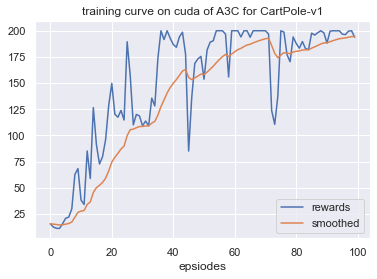

开始测试！
回合：1/200，奖励：200.00
回合：2/200，奖励：200.00
回合：3/200，奖励：196.00
回合：4/200，奖励：200.00
回合：5/200，奖励：200.00
回合：6/200，奖励：200.00
回合：7/200，奖励：200.00
回合：8/200，奖励：200.00
回合：9/200，奖励：200.00
回合：10/200，奖励：200.00
回合：11/200，奖励：200.00
回合：12/200，奖励：200.00
回合：13/200，奖励：200.00
回合：14/200，奖励：200.00
回合：15/200，奖励：200.00
回合：16/200，奖励：200.00
回合：17/200，奖励：200.00
回合：18/200，奖励：200.00
回合：19/200，奖励：200.00
回合：20/200，奖励：200.00
回合：21/200，奖励：200.00
回合：22/200，奖励：200.00
回合：23/200，奖励：200.00
回合：24/200，奖励：200.00
回合：25/200，奖励：200.00
回合：26/200，奖励：200.00
回合：27/200，奖励：200.00
回合：28/200，奖励：200.00
回合：29/200，奖励：200.00
回合：30/200，奖励：200.00
回合：31/200，奖励：200.00
回合：32/200，奖励：200.00
回合：33/200，奖励：200.00
回合：34/200，奖励：200.00
回合：35/200，奖励：200.00
回合：36/200，奖励：200.00
回合：37/200，奖励：200.00
回合：38/200，奖励：200.00
回合：39/200，奖励：200.00
回合：40/200，奖励：200.00
回合：41/200，奖励：200.00
回合：42/200，奖励：200.00
回合：43/200，奖励：200.00
回合：44/200，奖励：200.00
回合：45/200，奖励：200.00
回合：46/200，奖励：200.00
回合：47/200，奖励：200.00
回合：48/200，奖励：200.00
回合：49/200，奖励：200.00
回合：50/200，奖励：200.00
回合：

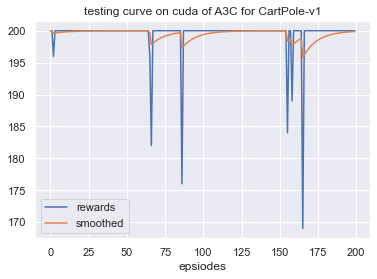

In [13]:
# 获取参数
cfg = Config() 
# 训练
env, envs, agent = env_agent_config(cfg)
res_dic = train(cfg, env, envs, agent)
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果